In [1]:
import numpy as np
import pandas as pd

In [2]:
class Node():
    def __init__(self, feature_name = None, threshold = None, left_branch = None, right_branch = None, leaf_value = None):
        '''
        class for each node in a decision tree
        '''
        self.feature_name = feature_name
        self.threshold = threshold
        self.left_branch = left_branch
        self.right_branch = right_branch
        self.leaf_value = leaf_value

In [64]:
class DecisionTree():
    def __init__(self, print_info = False):
        self.root = None
        self.print_info = print_info

    def fit(self, X, Y):
        self.root = self.create_tree(X, Y)
    
    def create_tree(self, X:np.ndarray, Y:np.ndarray):
        #find the best split and judge if stopping creterion are met
        stop, best_feature, best_threshold, split_data = self.find_best_split(X, Y)
        if not stop:
            #create branch
            if(self.print_info):
                print("branch_created")
            l_tree = self.create_tree(split_data['X_l'], split_data['Y_l'])
            r_tree = self.create_tree(split_data['X_r'], split_data['Y_r'])
            root = Node(best_feature, best_threshold, l_tree, r_tree, None)
            return root
        else:
            if(self.print_info):
                print("leaf_created")
            one_count = np.sum(Y)
            zero_count = len(Y)-one_count
            leaf_value = 0 if zero_count> one_count else 1
            return Node(leaf_value=leaf_value)



    def find_best_split(self, X:np.ndarray, Y:np.ndarray):
        #iterate each split
        #set the initial info gain to negative infinity
        max_split_entropy = 0
        max_info_gain_ratio = 0

        best_feature = 0
        best_threshold = 0 
        #iterate each possible split to find the best split
        #iterate each column
        total_samples = X.shape[0]

        split_data = {'X_l':None, 'Y_l':None, 'X_r':None, 'Y_r':None}
        for i in range(X.shape[1]):
            sorted_index = X[:, i].argsort()
            X = X[sorted_index]
            Y = Y[sorted_index]    
            #iterate each row
            for j in range(X.shape[0]):
                #if there are same value, continue
                if (j-1 >= 0 and X[j-1][i]==X[j][i]):
                        continue
                #j-1 >= 0 and X[j-i][i]==X[j][i]:
                l_split_X = X[:j]
                l_split_Y = Y[:j]
                r_split_X = X[j:]
                r_split_Y = Y[j:]
                # l_split_X = X[X[:,i]<X[j][i]]
                # l_split_Y = Y[X[:,i]<X[j][i]]
                # r_split_X = X[X[:,i]>=X[j][i]]
                # r_split_Y = Y[X[:,i]>=X[j][i]]
                if(self.print_info):
                    print("candidate split is: x_%d threshold = %.2f"%(i+1, X[j][i]))
                split_entropy, info_gain_ratio = self.calc_info_gain_ratio(l_split_Y, r_split_Y, total_samples)
                if split_entropy > max_split_entropy:
                    max_split_entropy = split_entropy
                if info_gain_ratio > max_info_gain_ratio:
                    max_info_gain_ratio = info_gain_ratio
                    best_feature = i
                    best_threshold = X[j][i]
                    split_data['X_l'] = l_split_X
                    split_data['Y_l'] = l_split_Y
                    split_data['X_r'] = r_split_X
                    split_data['Y_r'] = r_split_Y

        stop = False
        if(max_split_entropy==0 or max_info_gain_ratio==0):
            stop = True
        return stop, best_feature, best_threshold, split_data

    def calc_entropy(self, p):
        en = 0
        for i in p:
            if i==0:
                continue
            else:
                en = en - i*np.log2(i)
        return en
    
    def calc_info_gain_ratio(self, l_split_Y, r_split_Y, total_smaples):
        #Here we only consider two labels in {0, 1}
        l_count1 = np.sum(l_split_Y==1)
        r_count1 = np.sum(r_split_Y==1)
        total_1 = l_count1+r_count1
        l_len = len(l_split_Y)
        r_len = len(r_split_Y)
        split_entrophy = 0
        info_gain_ratio = 0
        info_gain = 0
        if l_len*r_len != 0:
            split_entrophy = self.calc_entropy([l_len/total_smaples, r_len/total_smaples])  
            Y_entropy = self.calc_entropy([total_1/total_smaples, 1-total_1/total_smaples])
            H_l = self.calc_entropy([l_count1/l_len, 1-l_count1/l_len]) 
            H_r = self.calc_entropy([r_count1/r_len, 1-r_count1/r_len]) 
            info_gain = Y_entropy-(l_len*H_l/total_smaples+r_len*H_r/total_smaples)
            info_gain_ratio = info_gain/split_entrophy
        else:
            split_entrophy = 0
            info_gain_ratio = 0
        if(self.print_info):
                print("    split entropy: %.3f  info gain: %.3f  gain ratio: %.3f "%(split_entrophy, info_gain, info_gain_ratio))
        return split_entrophy, info_gain_ratio
    
    def predict(self, X):
        pred = []
        for i in X:
            pred.append(self.make_prediction(i, self.root))
        return np.array(pred).reshape(-1,1)
    
    def make_prediction(self, x, tree:Node):
        feature = tree.feature_name
        if tree.leaf_value != None:
            return tree.leaf_value
        elif x[feature] < tree.threshold:
            return self.make_prediction(x, tree.left_branch)
        else:
            return self.make_prediction(x, tree.right_branch)
    
    def show(self, tree=None, indent="  "):

        if not tree:
            tree = self.root
        if tree.leaf_value is not None:
            #if this is the leaf
            print(tree.leaf_value)

        else:
            print("X_"+str(tree.feature_name+1), "<", tree.threshold , "?")
            print("%sleft:"%(indent), end="")
            self.show(tree.left_branch, indent+"   ")
            print("%sright:"%(indent), end="")
            self.show(tree.right_branch, indent+"  ")

    def calc_node(self, tree:Node=None):
        if tree == None:
            tree = self.root
        if tree.leaf_value != None:
            return 1
        else:
            return 1+self.calc_node(tree.left_branch)+self.calc_node(tree.right_branch)


In [60]:
col_index = ["x1","x2", "y"]
D1df = pd.read_csv("D1.txt", sep=" ", names = col_index)
feature_1 = np.array(D1df[["x1","x2"]])
label_1 = np.array(D1df["y"]).reshape(-1,1)

In [68]:
col_index = ["x1","x2", "y"]
D2df = pd.read_csv("D2.txt", sep=" ", names = col_index)
feature_2 = np.array(D2df[["x1","x2"]])
label_2 = np.array(D2df["y"]).reshape(-1,1)

In [65]:
mytree_1 = DecisionTree(print_info=False)
mytree_1.fit(feature_1, label_1)

In [69]:
mytree_2 = DecisionTree(print_info=False)
mytree_2.fit(feature_2, label_2)

In [71]:
mytree_2.calc_node()

61

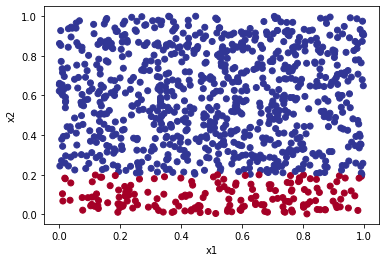

In [9]:
import matplotlib.pyplot as plt
plt.scatter(D1df['x1'],D1df['x2'], c = D1df['y'], cmap =plt.cm.RdYlBu)
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig('scatter_D1.pdf')

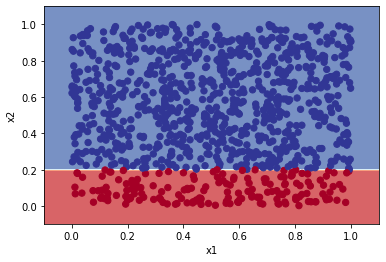

In [10]:
# code from https://psrivasin.medium.com/plotting-decision-boundaries-using-numpy-and-matplotlib-f5613d8acd19
x_min, x_max = D1df['x1'].min() - 0.1, D1df['x1'].max() + 0.1
y_min, y_max = D1df['x2'].min() - 0.1, D1df['x2'].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min,x_max, 100),
np.linspace(y_min, y_max, 100))
x_in = np.c_[xx.ravel(), yy.ravel()]
y_pred = mytree_1.predict(x_in)
y_pred = np.round(y_pred).reshape(xx.shape)
plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7 )
plt.scatter(D1df['x1'],D1df['x2'], c=D1df['y'], s=40, cmap=plt.cm.RdYlBu)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig("Decision_boundary_D1.pdf")

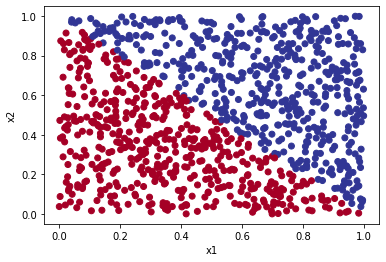

In [11]:
ax2 = plt.scatter(D2df['x1'],D2df['x2'], c = D2df['y'], cmap =plt.cm.RdYlBu)
fig2 = ax2.get_figure()
plt.xlabel('x1')
plt.ylabel('x2')
fig2.savefig('scatter_D2.pdf')

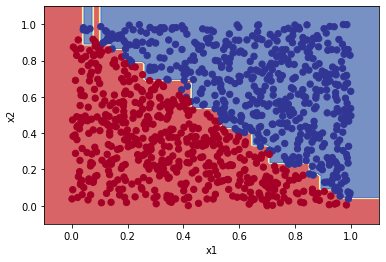

In [12]:
x_min, x_max = D2df['x1'].min() - 0.1, D2df['x1'].max() + 0.1
y_min, y_max = D2df['x2'].min() - 0.1, D2df['x2'].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min,x_max, 100),
np.linspace(y_min, y_max, 100))
x_in = np.c_[xx.ravel(), yy.ravel()]
y_pred = mytree_2.predict(x_in)
y_pred = np.round(y_pred).reshape(xx.shape)
plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7 )
plt.scatter(D2df['x1'],D2df['x2'], c=D2df['y'], s=40, cmap=plt.cm.RdYlBu)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig("Decision_boundary_D2.pdf")

In [13]:
D1df.head()

,x1,x2,y
0,0.264185,0.178456,0
1,0.409499,0.213456,1
2,0.926224,0.540329,1
3,0.573685,0.282145,1
4,0.953159,0.608121,1


In [14]:
col_index = ["x1","x2", "y"]
Dbigdf = pd.read_csv("Dbig.txt", sep=" ", names = col_index)

In [15]:
permutaion = np.arange(len(Dbigdf))
np.random.shuffle(permutaion)
Dbigdf = Dbigdf.loc[permutaion]
Dbigdf.iloc[0:32]
Train_list = []
for i in range(5):
    Train_list.append(Dbigdf.iloc[:32*pow(4, i)])
test_set = Dbigdf.iloc[8192:]

In [72]:
mytree_3 = DecisionTree()
err = []
feature_test = np.array(test_set[["x1","x2"]])
label_test = np.array(test_set["y"]).reshape(-1,1)
i = 0
num_node = []
for train_set in Train_list:
    feature_train = np.array(train_set[["x1","x2"]])
    label_train = np.array(train_set["y"]).reshape(-1,1)
    mytree_3.fit(feature_train, label_train)
    prediction = mytree_3.predict(feature_test)
    #print(sum(label_test.flatten()==prediction.flatten()))
    err.append(1-sum(label_test.flatten()==prediction.flatten())/len(label_test))
    num_node.append(mytree_3.calc_node())
    
    x_min, x_max = feature_train[:, 0].min() - 0.1, feature_train[:, 0].max() + 0.1
    y_min, y_max = feature_train[:, 1].min() - 0.1, feature_train[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min,x_max, 100), np.linspace(y_min, y_max, 100))
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_pred = mytree_3.predict(x_in)
    y_pred = np.round(y_pred).reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.8 )
    plt.scatter(feature_train[:, 0],feature_train[:, 1], c=label_train, s=5, cmap=plt.cm.RdYlBu, alpha=0.5)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.savefig("Decision_boundary_D"+str(32*pow(4, i))+".pdf")
    plt.clf()
    i=i+1

<Figure size 432x288 with 0 Axes>

In [76]:
np.round(err,3)

array([0.178, 0.082, 0.045, 0.03 , 0.018])

In [77]:
num_node

[15, 25, 53, 121, 265]

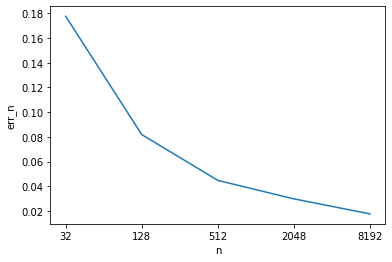

In [59]:
#plt.figure(figsize=(30,5))
errx = [32*pow(4, i) for i in range(5)]
plt.plot(err)
#plt.xscale('log')
plt.xticks([0,1,2,3,4], ["32","128","512","2048","8192"])
plt.xlabel('n')
plt.ylabel('err_n')
plt.savefig("err_n_mytree.pdf")

In [83]:
from sklearn import tree
err = []
feature_test = np.array(test_set[["x1","x2"]])
label_test = np.array(test_set["y"]).reshape(-1,1)
i = 0
num_node = []
for train_set in Train_list:
    feature_train = np.array(train_set[["x1","x2"]])
    label_train = np.array(train_set["y"]).reshape(-1,1)
    clf = tree.DecisionTreeClassifier(criterion="gini")
    clf = clf.fit(feature_train, label_train)
    prediction = clf.predict(feature_test)
    #print(sum(label_test.flatten()==prediction.flatten()))
    err.append(1-sum(label_test.flatten()==prediction.flatten())/len(label_test))
    num_node.append(clf.tree_.node_count)

In [84]:
err

[0.1415929203539823,
 0.0625,
 0.033738938053097356,
 0.025995575221238965,
 0.012168141592920345]

In [85]:
num_node

[13, 25, 49, 121, 245]

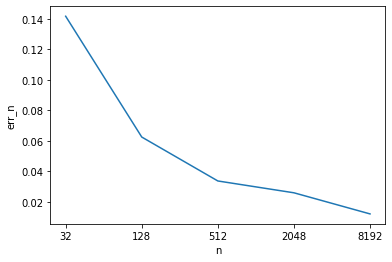

In [86]:
#plt.figure(figsize=(30,5))
errx = [32*pow(4, i) for i in range(5)]
plt.plot(err)
#plt.xscale('log')
plt.xticks([0,1,2,3,4], ["32","128","512","2048","8192"])
plt.xlabel('n')
plt.ylabel('err_n')
plt.savefig("err_n_mytree_sklearn.pdf")